In [1]:
from pathlib import Path
import json
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 220)


In [2]:
repo_root = Path.cwd().resolve()
if repo_root.name == 'analyses':
    repo_root = repo_root.parent

artifacts_dir = repo_root / 'artifacts'
full_dir = artifacts_dir / 'FULL'
p2_dir = artifacts_dir / 'P2'

if not full_dir.exists():
    raise FileNotFoundError(f'Missing folder: {full_dir}')
if not p2_dir.exists():
    raise FileNotFoundError(f'Missing folder: {p2_dir}')

print('repo_root   :', repo_root)
print('artifacts   :', artifacts_dir)
print('FULL folder :', full_dir)
print('P2 folder   :', p2_dir)


repo_root   : C:\Users\matma\Desktop\ITU\CV\ADVCV_final_project
artifacts   : C:\Users\matma\Desktop\ITU\CV\ADVCV_final_project\artifacts
FULL folder : C:\Users\matma\Desktop\ITU\CV\ADVCV_final_project\artifacts\FULL
P2 folder   : C:\Users\matma\Desktop\ITU\CV\ADVCV_final_project\artifacts\P2


In [3]:
EVAL_NAMES = ['test_evaluation', 'test_evaluation_last', 'test_evaluation_conf_selected']

def _read_metrics_csv(path: Path) -> dict:
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]
    return dict(zip(df['metric'], df['value']))

def _extract_per_class(metrics_map: dict) -> pd.DataFrame:
    classes = sorted({k.split('AP50_')[1] for k in metrics_map if k.startswith('AP50_')})
    rows = []
    for c in classes:
        rows.append({
            'class': c,
            'AP50': metrics_map.get(f'AP50_{c}', np.nan),
            'AP50-95': metrics_map.get(f'AP50-95_{c}', np.nan),
            'Precision': metrics_map.get(f'Precision_{c}', np.nan),
            'Recall': metrics_map.get(f'Recall_{c}', np.nan),
        })
    return pd.DataFrame(rows)

def _load_eval_dir(run_outputs: Path, eval_name: str):
    d = run_outputs / eval_name
    if not d.exists():
        return None

    out = {'name': eval_name, 'dir': d}

    metrics_csv = d / 'metrics.csv'
    if metrics_csv.exists():
        metrics_map = _read_metrics_csv(metrics_csv)
        out['metrics_map'] = metrics_map
        out['per_class'] = _extract_per_class(metrics_map)
    else:
        out['metrics_map'] = {}
        out['per_class'] = pd.DataFrame()

    errors_csv = d / 'errors.csv'
    out['errors'] = pd.read_csv(errors_csv) if errors_csv.exists() else pd.DataFrame()

    misclass_csv = d / 'misclass_summary.csv'
    out['misclass'] = pd.read_csv(misclass_csv) if misclass_csv.exists() else pd.DataFrame()

    return out

def load_bundle(run_dir: Path, label: str) -> dict:
    run_outputs = run_dir / 'run_outputs'
    if not run_outputs.exists():
        raise FileNotFoundError(f'Missing run_outputs in {run_dir}')

    results_path = run_outputs / 'results.csv'
    if not results_path.exists():
        raise FileNotFoundError(f'Missing results.csv: {results_path}')
    results = pd.read_csv(results_path)
    results.columns = [c.strip() for c in results.columns]

    args_path = run_outputs / 'args.yaml'
    args = yaml.safe_load(args_path.read_text(encoding='utf-8')) if args_path.exists() else {}

    manifest_path = run_outputs / 'run_manifest.json'
    manifest = json.loads(manifest_path.read_text(encoding='utf-8')) if manifest_path.exists() else {}

    evals = {}
    for name in EVAL_NAMES:
        obj = _load_eval_dir(run_outputs, name)
        if obj is not None:
            evals[name] = obj

    if 'test_evaluation' not in evals:
        raise FileNotFoundError(f"{label}: expected test_evaluation folder in {run_outputs}")

    return {
        'label': label,
        'run_dir': run_dir,
        'run_outputs': run_outputs,
        'results': results,
        'args': args,
        'manifest': manifest,
        'evals': evals,
    }


In [4]:
full = load_bundle(full_dir, 'FULL')
p2 = load_bundle(p2_dir, 'P2')

print('Loaded runs:')
print(' - FULL:', full['run_dir'])
print(' - P2  :', p2['run_dir'])
print()
print('Evaluation folders:')
print('FULL:', list(full['evals'].keys()))
print('P2  :', list(p2['evals'].keys()))


Loaded runs:
 - FULL: C:\Users\matma\Desktop\ITU\CV\ADVCV_final_project\artifacts\FULL
 - P2  : C:\Users\matma\Desktop\ITU\CV\ADVCV_final_project\artifacts\P2

Evaluation folders:
FULL: ['test_evaluation', 'test_evaluation_last']
P2  : ['test_evaluation', 'test_evaluation_last', 'test_evaluation_conf_selected']


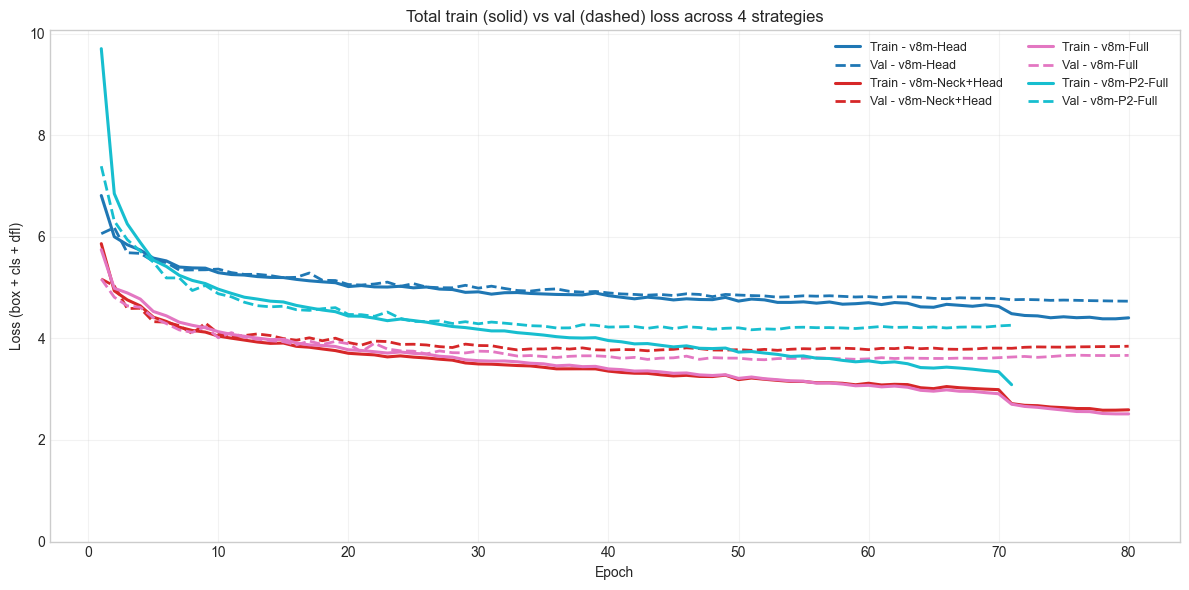

,run,train_total_last,val_total_last,gap_last(val-train)
2,v8m-Full,2.51368,3.66559,1.15191
0,v8m-Head,4.40491,4.73258,0.32767
1,v8m-Neck+Head,2.59398,3.84605,1.25207
3,v8m-P2-Full,3.08921,4.25924,1.17003


In [5]:
# Total train/val loss curves for the four standardized strategies.
def _total_loss(df: pd.DataFrame, train: bool) -> pd.Series:
    cols = ['train/box_loss', 'train/cls_loss', 'train/dfl_loss'] if train else ['val/box_loss', 'val/cls_loss', 'val/dfl_loss']
    return df[cols].sum(axis=1)

loss_runs = [
    ('v8m-Head', 'HEAD_ONLY_2'),
    ('v8m-Neck+Head', 'FREEZE_BACKBONE_2'),
    ('v8m-Full', 'FULL'),
    ('v8m-P2-Full', 'P2'),
]

run_data = []
for label, folder in loss_runs:
    rpath = artifacts_dir / folder / 'run_outputs' / 'results.csv'
    if not rpath.exists():
        raise FileNotFoundError(f'Missing results.csv for {label}: {rpath}')
    df = pd.read_csv(rpath)
    df.columns = [c.strip() for c in df.columns]
    need = ['train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss']
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise ValueError(f'{label} missing loss columns: {missing}')
    epoch = df['epoch'] if 'epoch' in df.columns else np.arange(len(df))
    run_data.append({
        'label': label,
        'epoch': epoch,
        'train_total': _total_loss(df, True),
        'val_total': _total_loss(df, False),
    })

fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.tab10(np.linspace(0, 1, len(run_data)))

for color, rd in zip(colors, run_data):
    ax.plot(rd['epoch'], rd['train_total'], color=color, linewidth=2.2, label=f"Train - {rd['label']}")
    ax.plot(rd['epoch'], rd['val_total'], color=color, linewidth=2.0, linestyle='--', label=f"Val - {rd['label']}")

ax.set_ylim(bottom=0)
ax.set_title('Total train (solid) vs val (dashed) loss across 4 strategies')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (box + cls + dfl)')
ax.grid(alpha=0.25)
ax.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

loss_summary = pd.DataFrame([
    {
        'run': rd['label'],
        'train_total_last': float(rd['train_total'].iloc[-1]),
        'val_total_last': float(rd['val_total'].iloc[-1]),
        'gap_last(val-train)': float(rd['val_total'].iloc[-1] - rd['train_total'].iloc[-1]),
    }
    for rd in run_data
])
display(loss_summary.sort_values('run'))


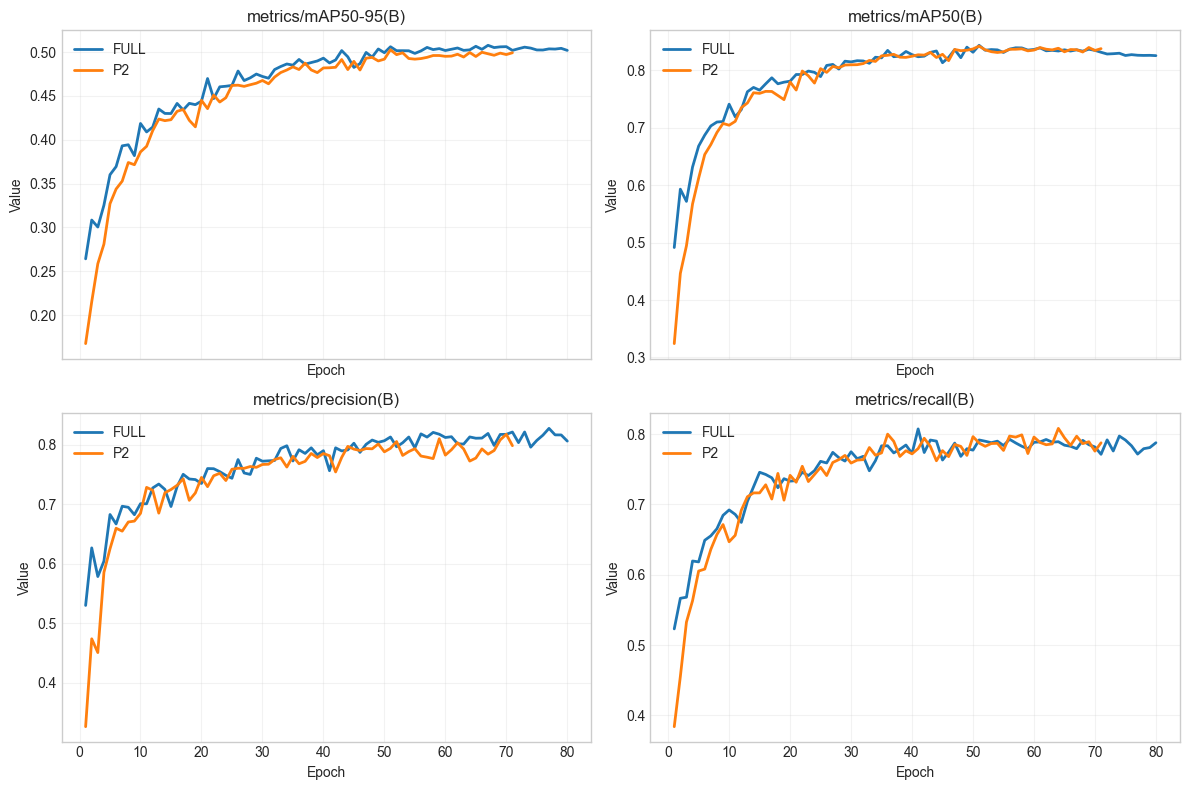

,run,point,epoch,metrics/mAP50(B),metrics/mAP50-95(B),metrics/precision(B),metrics/recall(B)
0,FULL,best_val_epoch,67.0,0.83553,0.50768,0.81921,0.77943
1,FULL,last_epoch,80.0,0.82539,0.50190,0.80637,0.78787
2,P2,best_val_epoch,51.0,0.84197,0.50262,0.79417,0.78744
3,P2,last_epoch,71.0,0.83758,0.49920,0.79865,0.78775


In [6]:
metrics_cols = ['metrics/mAP50-95(B)', 'metrics/mAP50(B)', 'metrics/precision(B)', 'metrics/recall(B)']

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.ravel()

for ax, col in zip(axes, metrics_cols):
    ax.plot(full['results']['epoch'], full['results'][col], label='FULL', linewidth=2)
    ax.plot(p2['results']['epoch'], p2['results'][col], label='P2', linewidth=2)
    ax.set_title(col)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Value')
    ax.grid(alpha=0.25)
    ax.legend()

plt.tight_layout()
plt.show()

def _best_val_row(df: pd.DataFrame, metric='metrics/mAP50-95(B)') -> pd.Series:
    idx = df[metric].idxmax()
    return df.loc[idx, ['epoch', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'metrics/precision(B)', 'metrics/recall(B)']]

val_dyn = pd.DataFrame([
    {'run': 'FULL', 'point': 'best_val_epoch', **_best_val_row(full['results']).to_dict()},
    {'run': 'FULL', 'point': 'last_epoch', **full['results'].iloc[-1][['epoch', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'metrics/precision(B)', 'metrics/recall(B)']].to_dict()},
    {'run': 'P2', 'point': 'best_val_epoch', **_best_val_row(p2['results']).to_dict()},
    {'run': 'P2', 'point': 'last_epoch', **p2['results'].iloc[-1][['epoch', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'metrics/precision(B)', 'metrics/recall(B)']].to_dict()},
])
display(val_dyn)


Checkpoint effect on test set (best vs last)

In [8]:
def _eval_row(bundle: dict, model_name: str, eval_name: str) -> dict:
    m = bundle['evals'][eval_name]['metrics_map']
    return {
        'model': model_name,
        'evaluation': eval_name,
        'conf_threshold': m.get('conf_threshold', np.nan),
        'mAP50': m.get('mAP50', np.nan),
        'mAP50-95': m.get('mAP50-95', np.nan),
        'precision': m.get('precision', np.nan),
        'recall': m.get('recall', np.nan),
        'coco/APs': m.get('coco/APs', np.nan),
        'coco/APm': m.get('coco/APm', np.nan),
        'coco/APl': m.get('coco/APl', np.nan),
    }

rows = []
for eval_name in ['test_evaluation', 'test_evaluation_last']:
    if eval_name in full['evals']:
        rows.append(_eval_row(full, 'FULL', eval_name))
    if eval_name in p2['evals']:
        rows.append(_eval_row(p2, 'P2', eval_name))

df_best_last = pd.DataFrame(rows)
display(df_best_last)


,model,evaluation,conf_threshold,mAP50,mAP50-95,precision,recall,coco/APs,coco/APm,coco/APl
0,FULL,test_evaluation,0.25,0.8438809998186328,0.5448008775322059,0.792801522712325,0.8244943340752156,0.39505414567501373,0.5263605869508226,0.5849404266972591
1,P2,test_evaluation,0.25,0.8414347714696407,0.5306168925689357,0.8014047036575702,0.792260464414895,0.37506656284331347,0.4934805618308105,0.38339969250924355
2,FULL,test_evaluation_last,0.25,0.8377758803716797,0.5414807827981094,0.8379738607321787,0.7930348126050824,0.38793320517243346,0.5272696311066459,0.5989470822494974
3,P2,test_evaluation_last,0.25,0.8461269283413789,0.5340286671613871,0.8109331731414857,0.8069587097684711,0.37233651105827403,0.5269249265149295,0.5086492418171032


Per-class comparison (default test evaluation)


,class,FULL_AP50,FULL_AP50-95,FULL_Precision,FULL_Recall,P2_AP50,P2_AP50-95,P2_Precision,P2_Recall,delta_AP50,delta_AP50-95,delta_Precision,delta_Recall
7,SH,0.915921,0.658087,0.823279,0.884892,0.911062,0.590596,0.813720,0.879946,-0.004859,-0.067491,-0.009560,-0.004946
2,CS,0.707091,0.452092,0.687507,0.680115,0.692761,0.421098,0.700576,0.600111,-0.014330,-0.030994,0.013070,-0.080004
5,OP,0.900801,0.595652,0.823810,0.897233,0.892686,0.568232,0.825397,0.861660,-0.008114,-0.027420,0.001588,-0.035573
1,CFO,0.706245,0.464165,0.652510,0.702586,0.687858,0.453088,0.669396,0.633621,-0.018387,-0.011077,0.016886,-0.068966
6,SC,0.845864,0.527970,0.818012,0.801992,0.858511,0.521258,0.841427,0.792635,0.012647,-0.006713,0.023415,-0.009357
3,HB,0.968274,0.835883,0.907439,0.944862,0.976178,0.838625,0.889995,0.959900,0.007904,0.002742,-0.017445,0.015038
0,BMFO,0.899300,0.517754,0.817540,0.909483,0.896210,0.520955,0.811162,0.866379,-0.003090,0.003200,-0.006378,-0.043103
4,MB,0.810124,0.435796,0.802544,0.792507,0.814086,0.440727,0.797709,0.768802,0.003961,0.004931,-0.004835,-0.023705
8,SP,0.841308,0.415807,0.802573,0.806778,0.843560,0.420973,0.863260,0.767290,0.002253,0.005165,0.060687,-0.039488


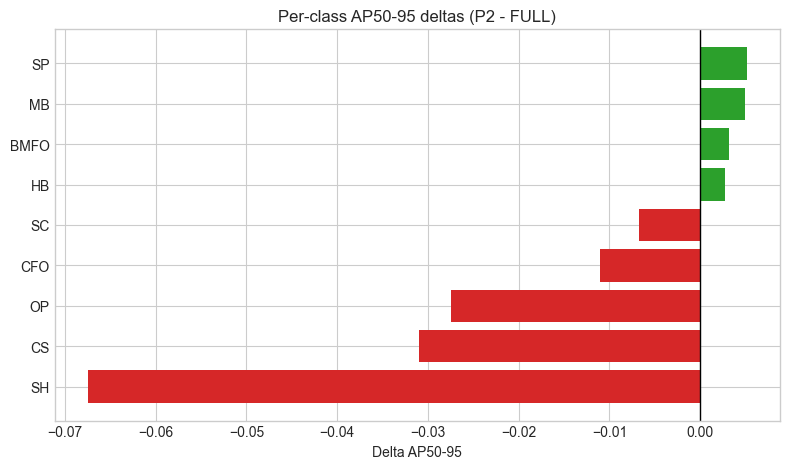

In [9]:

# Robust version: force numeric columns before delta computation
pc_full = full['evals']['test_evaluation']['per_class'].rename(columns={
    'AP50': 'FULL_AP50',
    'AP50-95': 'FULL_AP50-95',
    'Precision': 'FULL_Precision',
    'Recall': 'FULL_Recall'
}).copy()

pc_p2 = p2['evals']['test_evaluation']['per_class'].rename(columns={
    'AP50': 'P2_AP50',
    'AP50-95': 'P2_AP50-95',
    'Precision': 'P2_Precision',
    'Recall': 'P2_Recall'
}).copy()

pc = pc_full.merge(pc_p2, on='class', how='outer')

num_cols = [
    'FULL_AP50', 'FULL_AP50-95', 'FULL_Precision', 'FULL_Recall',
    'P2_AP50', 'P2_AP50-95', 'P2_Precision', 'P2_Recall'
]
for c in num_cols:
    pc[c] = pd.to_numeric(pc[c], errors='coerce')

pc['delta_AP50'] = pc['P2_AP50'] - pc['FULL_AP50']
pc['delta_AP50-95'] = pc['P2_AP50-95'] - pc['FULL_AP50-95']
pc['delta_Precision'] = pc['P2_Precision'] - pc['FULL_Precision']
pc['delta_Recall'] = pc['P2_Recall'] - pc['FULL_Recall']

pc = pc.sort_values('delta_AP50-95')
display(pc)

plot_pc = pc.dropna(subset=['delta_AP50-95']).copy()

plt.figure(figsize=(8, 4.8))
colors = ['#2ca02c' if v > 0 else '#d62728' for v in plot_pc['delta_AP50-95']]
plt.barh(plot_pc['class'], plot_pc['delta_AP50-95'], color=colors)
plt.axvline(0, color='black', linewidth=1)
plt.title('Per-class AP50-95 deltas (P2 - FULL)')
plt.xlabel('Delta AP50-95')
plt.tight_layout()
plt.show()

In [10]:
err_full = full['evals']['test_evaluation']['errors']
err_p2 = p2['evals']['test_evaluation']['errors']

if err_full.empty or err_p2.empty:
    print('errors.csv not available in one of the runs.')
else:
    counts_full = err_full['error_type'].value_counts().rename('FULL')
    counts_p2 = err_p2['error_type'].value_counts().rename('P2')
    err_cmp = pd.concat([counts_full, counts_p2], axis=1).fillna(0).astype(int)
    err_cmp['delta_P2_minus_FULL'] = err_cmp['P2'] - err_cmp['FULL']
    display(err_cmp)

    miss_full = err_full.loc[err_full['error_type'] == 'missed', 'true_class'].value_counts().rename('FULL_missed')
    miss_p2 = err_p2.loc[err_p2['error_type'] == 'missed', 'true_class'].value_counts().rename('P2_missed')
    miss_cmp = pd.concat([miss_full, miss_p2], axis=1).fillna(0).astype(int)
    miss_cmp['delta_P2_minus_FULL'] = miss_cmp['P2_missed'] - miss_cmp['FULL_missed']
    display(miss_cmp.sort_values('delta_P2_minus_FULL', ascending=False))


,FULL,P2,delta_P2_minus_FULL
error_type,,,
false_positive,881,952,71
missed,398,413,15
wrong_class,96,103,7


,FULL_missed,P2_missed,delta_P2_minus_FULL
true_class,,,
SP,92,105,13
CS,113,120,7
BMFO,15,20,5
MB,59,60,1
SH,13,14,1
OP,18,17,-1
SC,24,22,-2
CFO,50,46,-4
HB,14,9,-5


P2 confidence-threshold tuning (validation-first)

We use uses `val_conf_sweep.csv` to select `conf*` by maximum validation F1, then check test metrics at:
- default `conf=0.25` (`test_evaluation`),
- selected `conf*` (`test_evaluation_conf_selected`, if present).


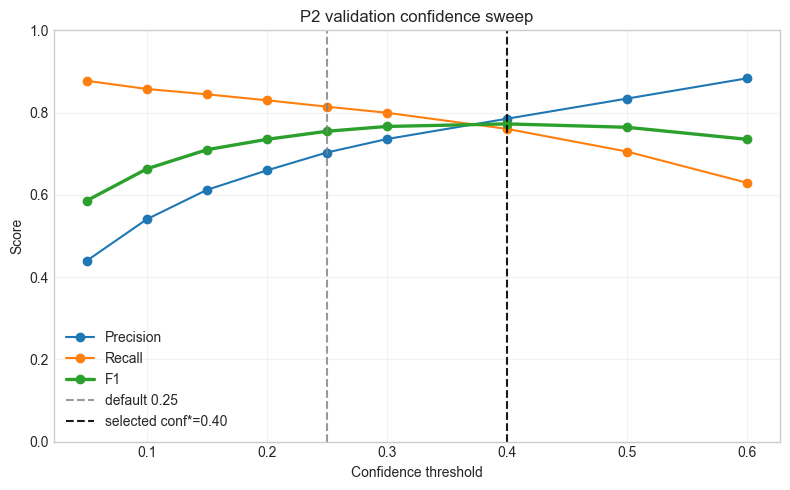

Selected conf* from validation: 0.40


In [11]:
val_sweep_path = p2['run_outputs'] / 'val_conf_sweep.csv'
if not val_sweep_path.exists():
    raise FileNotFoundError(f'Missing: {val_sweep_path}')

val_sw = pd.read_csv(val_sweep_path)
val_sw.columns = [c.strip() for c in val_sw.columns]

if 'f1_sel' not in val_sw.columns and 'f1_err_based' in val_sw.columns:
    val_sw = val_sw.rename(columns={
        'precision_err_based': 'precision_sel',
        'recall_err_based': 'recall_sel',
        'f1_err_based': 'f1_sel',
    })

for c in ['conf', 'precision_sel', 'recall_sel', 'f1_sel']:
    if c not in val_sw.columns:
        raise ValueError(f'Missing required column in val_conf_sweep.csv: {c}')

val_sw = val_sw.sort_values('conf').reset_index(drop=True)
conf_star = float(val_sw.loc[val_sw['f1_sel'].idxmax(), 'conf'])

plt.figure(figsize=(8, 5))
plt.plot(val_sw['conf'], val_sw['precision_sel'], marker='o', label='Precision')
plt.plot(val_sw['conf'], val_sw['recall_sel'], marker='o', label='Recall')
plt.plot(val_sw['conf'], val_sw['f1_sel'], marker='o', linewidth=2.4, label='F1')
plt.axvline(0.25, linestyle='--', color='gray', alpha=0.8, label='default 0.25')
plt.axvline(conf_star, linestyle='--', color='black', alpha=0.9, label=f'selected conf*={conf_star:.2f}')
plt.title('P2 validation confidence sweep')
plt.xlabel('Confidence threshold')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(alpha=0.25)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

print(f'Selected conf* from validation: {conf_star:.2f}')


In [12]:
def _metrics_row(eval_obj: dict, label: str) -> dict:
    m = eval_obj['metrics_map']
    return {
        'evaluation': label,
        'conf_threshold': _to_float(m.get('conf_threshold', np.nan)),
        'mAP50': _to_float(m.get('mAP50', np.nan)),
        'mAP50-95': _to_float(m.get('mAP50-95', np.nan)),
        'precision': _to_float(m.get('precision', np.nan)),
        'recall': _to_float(m.get('recall', np.nan)),
        'coco/APs': _to_float(m.get('coco/APs', np.nan)),
        'coco/APm': _to_float(m.get('coco/APm', np.nan)),
        'coco/APl': _to_float(m.get('coco/APl', np.nan)),
    }

rows = []
rows.append(_metrics_row(p2['evals']['test_evaluation'], 'P2 test @ default conf=0.25'))

if 'test_evaluation_conf_selected' in p2['evals']:
    rows.append(_metrics_row(p2['evals']['test_evaluation_conf_selected'], 'P2 test @ val-selected conf*'))
if 'test_evaluation_last' in p2['evals']:
    rows.append(_metrics_row(p2['evals']['test_evaluation_last'], 'P2 last.pt @ conf=0.25'))

df_p2_threshold = pd.DataFrame(rows)

# Force numeric columns in case any value comes as string
num_cols = ['conf_threshold', 'mAP50', 'mAP50-95', 'precision', 'recall', 'coco/APs', 'coco/APm', 'coco/APl']
for c in num_cols:
    df_p2_threshold[c] = pd.to_numeric(df_p2_threshold[c], errors='coerce')

display(df_p2_threshold)

if len(df_p2_threshold) >= 2:
    base = df_p2_threshold.iloc[0]
    for i in range(1, len(df_p2_threshold)):
        row = df_p2_threshold.iloc[i]
        print()
        print('Delta vs default for:', row['evaluation'])
        print('  mAP50      :', row['mAP50'] - base['mAP50'])
        print('  mAP50-95   :', row['mAP50-95'] - base['mAP50-95'])
        print('  precision  :', row['precision'] - base['precision'])
        print('  recall     :', row['recall'] - base['recall'])


,evaluation,conf_threshold,mAP50,mAP50-95,precision,recall,coco/APs,coco/APm,coco/APl
0,P2 test @ default conf=0.25,0.25,0.841435,0.530617,0.801405,0.792260,0.375067,0.493481,0.383400
1,P2 test @ val-selected conf*,0.40,0.828025,0.528840,0.810471,0.786953,0.362131,0.474816,0.375546
2,P2 last.pt @ conf=0.25,0.25,0.846127,0.534029,0.810933,0.806959,0.372337,0.526925,0.508649



Delta vs default for: P2 test @ val-selected conf*
  mAP50      : -0.013409368497002583
  mAP50-95   : -0.001776773373809215
  precision  : 0.009066450487833055
  recall     : -0.005307316359854375

Delta vs default for: P2 last.pt @ conf=0.25
  mAP50      : 0.0046921568717381845
  mAP50-95   : 0.0034117745924513443
  precision  : 0.009528469483915503
  recall     : 0.014698245353576112


In [13]:
# 4-model standardized matrix setup (dataframes + CSV only)
artifact_root = artifacts_dir
out_dir = repo_root / 'analyses'
out_dir.mkdir(parents=True, exist_ok=True)

RUNS_ALL = [
    ('YOLOv8m (Head-only fine-tuning)', 'HEAD_ONLY_2'),
    ('YOLOv8m (Backbone frozen; Neck+Head fine-tuning)', 'FREEZE_BACKBONE_2'),
    ('YOLOv8m (Full fine-tuning)', 'FULL'),
    ('YOLOv8m-P2 (Full fine-tuning)', 'P2'),
]

RUNS_CLASS = [
    ('YOLOv8m Head', 'HEAD_ONLY_2'),
    ('YOLOv8m Neck+Head', 'FREEZE_BACKBONE_2'),
    ('YOLOv8m Full', 'FULL'),
    ('YOLOv8m-P2 Full', 'P2'),
]

def find_eval_dir(run_folder: str) -> Path:
    run_outputs = artifact_root / run_folder / 'run_outputs'
    for d in ['test_evaluation', 'test_evaluation_last']:
        p = run_outputs / d
        if p.exists():
            return p
    raise FileNotFoundError(f'No test evaluation folder for {run_folder}')

def load_metrics_map(run_folder: str) -> dict:
    eval_dir = find_eval_dir(run_folder)
    mdf = pd.read_csv(eval_dir / 'metrics.csv')
    return dict(zip(mdf['metric'], mdf['value']))

def load_error_counts(run_folder: str) -> dict:
    eval_dir = find_eval_dir(run_folder)
    edf = pd.read_csv(eval_dir / 'errors.csv')
    vc = edf['error_type'].value_counts()
    return {
        'false_positive': int(vc.get('false_positive', 0)),
        'missed': int(vc.get('missed', 0)),
        'wrong_class': int(vc.get('wrong_class', 0)),
    }

def extract_per_class(metrics_map: dict) -> pd.DataFrame:
    classes = sorted({k.replace('AP50_', '') for k in metrics_map.keys() if k.startswith('AP50_')})
    rows = []
    for c in classes:
        rows.append({
            'class': c,
            'AP50': float(metrics_map.get(f'AP50_{c}', np.nan)),
            'AP50-95': float(metrics_map.get(f'AP50-95_{c}', np.nan)),
            'Precision': float(metrics_map.get(f'Precision_{c}', np.nan)),
            'Recall': float(metrics_map.get(f'Recall_{c}', np.nan)),
        })
    return pd.DataFrame(rows)

print('Using artifact root:', artifact_root)
for _, folder in RUNS_ALL:
    print(folder, (artifact_root / folder).exists())


Using artifact root: C:\Users\matma\Desktop\ITU\CV\ADVCV_final_project\artifacts
HEAD_ONLY_2 True
FREEZE_BACKBONE_2 True
FULL True
P2 True


In [14]:
# Global results matrix
rows = []

for model_name, folder in RUNS_ALL:
    m = load_metrics_map(folder)
    e = load_error_counts(folder)

    fp = e["false_positive"] + e["wrong_class"]
    fn = e["missed"] + e["wrong_class"]
    precision = float(m.get("precision", np.nan))
    recall = float(m.get("recall", np.nan))
    f1 = (2 * precision * recall / (precision + recall)) if np.isfinite(precision) and np.isfinite(recall) and (precision + recall) > 0 else np.nan

    rows.append({
        "Model": model_name,
        "IoU threshold": 0.50,
        "FP": fp,
        "FN": fn,
        "Misclassifications": e["wrong_class"],
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "mAP@50": float(m.get("mAP50", np.nan)),
        "mAP@50-95": float(m.get("mAP50-95", np.nan)),
        "AP_small": float(m.get("coco/APs", np.nan)),
        "AP_medium": float(m.get("coco/APm", np.nan)),
        "AP_large": float(m.get("coco/APl", np.nan)),
    })

df_results_matrix = pd.DataFrame(rows)
for c in ["Precision", "Recall", "F1", "mAP@50", "mAP@50-95", "AP_small", "AP_medium", "AP_large"]:
    df_results_matrix[c] = pd.to_numeric(df_results_matrix[c], errors="coerce").round(4)

display(df_results_matrix)
df_results_matrix.to_csv(out_dir / "model_results_matrix.csv", index=False)
print("Saved:", out_dir / "model_results_matrix.csv")

# Per-class long and wide matrices
class_rows = []
for model_name, folder in RUNS_CLASS:
    m = load_metrics_map(folder)
    pc = extract_per_class(m)
    pc["Model"] = model_name
    class_rows.append(pc)

df_class_long = pd.concat(class_rows, ignore_index=True)
display(df_class_long.head())

df_class_matrix = (
    df_class_long
    .set_index(["class", "Model"])[["AP50", "AP50-95", "Precision", "Recall"]]
    .unstack("Model")
)
df_class_matrix = df_class_matrix.swaplevel(0, 1, axis=1).sort_index(axis=1, level=0)
df_class_matrix.columns = [f"{model} | {metric}" for model, metric in df_class_matrix.columns]
df_class_matrix = df_class_matrix.round(4)

display(df_class_matrix)
df_class_matrix.to_csv(out_dir / "by_class_performance_matrix.csv")
print("Saved:", out_dir / "by_class_performance_matrix.csv")


,Model,IoU threshold,FP,FN,Misclassifications,Precision,Recall,F1,mAP@50,mAP@50-95,AP_small,AP_medium,AP_large
0,YOLOv8m (Head-only fine-tuning),0.5,1343,1124,127,0.6331,0.5986,0.6153,0.6349,0.3515,0.2137,0.2427,0.2363
1,YOLOv8m (Backbone frozen; Neck+Head fine-tuning),0.5,1042,597,126,0.7945,0.7455,0.7692,0.7961,0.4973,0.3601,0.4717,0.6140
2,YOLOv8m (Full fine-tuning),0.5,977,494,96,0.7928,0.8245,0.8083,0.8439,0.5448,0.3951,0.5264,0.5849
3,YOLOv8m-P2 (Full fine-tuning),0.5,1055,516,103,0.8014,0.7923,0.7968,0.8414,0.5306,0.3751,0.4935,0.3834


Saved: C:\Users\matma\Desktop\ITU\CV\ADVCV_final_project\analyses\model_results_matrix.csv


,class,AP50,AP50-95,Precision,Recall,Model
0,BMFO,0.742736,0.385732,0.721461,0.681034,YOLOv8m Head
1,CFO,0.476069,0.292516,0.515625,0.426724,YOLOv8m Head
2,CS,0.298855,0.158567,0.410377,0.250720,YOLOv8m Head
3,HB,0.924228,0.757243,0.720077,0.934837,YOLOv8m Head
4,MB,0.630998,0.297317,0.664430,0.551532,YOLOv8m Head


,YOLOv8m Full | AP50,YOLOv8m Full | AP50-95,YOLOv8m Full | Precision,YOLOv8m Full | Recall,YOLOv8m Head | AP50,YOLOv8m Head | AP50-95,YOLOv8m Head | Precision,YOLOv8m Head | Recall,YOLOv8m Neck+Head | AP50,YOLOv8m Neck+Head | AP50-95,YOLOv8m Neck+Head | Precision,YOLOv8m Neck+Head | Recall,YOLOv8m-P2 Full | AP50,YOLOv8m-P2 Full | AP50-95,YOLOv8m-P2 Full | Precision,YOLOv8m-P2 Full | Recall
class,,,,,,,,,,,,,,,,
BMFO,0.8993,0.5178,0.8175,0.9095,0.7427,0.3857,0.7215,0.6810,0.8517,0.4703,0.8186,0.8276,0.8962,0.5210,0.8112,0.8664
CFO,0.7062,0.4642,0.6525,0.7026,0.4761,0.2925,0.5156,0.4267,0.6289,0.4078,0.6292,0.5862,0.6879,0.4531,0.6694,0.6336
CS,0.7071,0.4521,0.6875,0.6801,0.2989,0.1586,0.4104,0.2507,0.6405,0.3977,0.6554,0.5533,0.6928,0.4211,0.7006,0.6001
HB,0.9683,0.8359,0.9074,0.9449,0.9242,0.7572,0.7201,0.9348,0.9553,0.8200,0.9203,0.9264,0.9762,0.8386,0.8900,0.9599
MB,0.8101,0.4358,0.8025,0.7925,0.6310,0.2973,0.6644,0.5515,0.7522,0.3767,0.8089,0.6880,0.8141,0.4407,0.7977,0.7688
OP,0.9008,0.5957,0.8238,0.8972,0.6273,0.2950,0.6509,0.5968,0.8817,0.5442,0.8513,0.8370,0.8927,0.5682,0.8254,0.8617
SC,0.8459,0.5280,0.8180,0.8020,0.7319,0.3937,0.7319,0.7137,0.8198,0.5022,0.8028,0.7604,0.8585,0.5213,0.8414,0.7926
SH,0.9159,0.6581,0.8233,0.8849,0.6559,0.3166,0.6364,0.6547,0.8563,0.5828,0.8471,0.8273,0.9111,0.5906,0.8137,0.8799
SP,0.8413,0.4158,0.8026,0.8068,0.6260,0.2673,0.6466,0.5769,0.7789,0.3741,0.8165,0.7031,0.8436,0.4210,0.8633,0.7673


Saved: C:\Users\matma\Desktop\ITU\CV\ADVCV_final_project\analyses\by_class_performance_matrix.csv
